# Transcription Prediction

## Description

<img src='header.jpeg'></img>

## Libraries and data import

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import combinations
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from nltk.tokenize import RegexpTokenizer
import lightgbm as lgb
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model
from nltk.corpus import stopwords
import gensim
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Using TensorFlow backend.
D:\Soft\Anaconda\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [3]:
word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [4]:
data = pd.read_csv('mtsamples.csv')
print(data.shape)
data.head(2)

(4999, 6)


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."


In [3]:
data = data.drop('Unnamed: 0', axis = 1)

In [4]:
data.head(3)

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."


$Description$ field represents the short description of full transcription

$Transcription$ represents the full text of description - the field we need

In [5]:
data.iloc[0,3]

'SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa was erythematous and swollen.  Only clear drainage was seen.  TMs were clear.,Neck:  Supple without adenopathy.,

$Medical speciality$ describes the kind of medical treatment needed for the case. Let's look at the values

In [6]:
data['medical_specialty'].value_counts()

 Surgery                          1103
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        372
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  230
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Obstetrics / Gynecology           160
 Urology                           158
 Discharge Summary                 108
 ENT - Otolaryngology               98
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    62
 Psychiatry / Psychology            53
 Office Notes                       51
 Podiatry                           47
 Dermatology                        29
 Dentistry                          27
 Cosmetic / Plastic Surge

We will use $transcription$ field as raw data, and $medical speciality$ as target to predict. Other fields we would not need in this task

In [5]:
data = data[['transcription', 'medical_specialty']]

## Preprocessing procedures

In [81]:
def standardize_text(df, text_field):
    df_temp = df.copy(deep = True)
    df_temp[text_field] = df_temp[text_field].str.replace(r"http\S+", "")
    df_temp[text_field] = df_temp[text_field].str.replace(r"http", "")
    df_temp[text_field] = df_temp[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df_temp[text_field] = df_temp[text_field].str.lower()
    return df_temp

def basic_preprocessing(df):
    
    #df = df.rename(index = str, columns = {'transcription': 'text'})
    
    df = df.drop(df[df['text'].isna()].index)
    df = standardize_text(df, "text")
    
    le = LabelEncoder()
    le.fit(df['medical_specialty'])
    df.loc[:, 'class_label'] = le.transform(df['medical_specialty'])
    
    tokenizer = RegexpTokenizer(r'\w+')

    df["tokens"] = df["text"].apply(tokenizer.tokenize)
    
    return df

def count_preprocessing(df):
    
    df = basic_preprocessing(df)

    count_vectorizer = CountVectorizer()
    count_vectorizer.fit(df)

    list_corpus = df["text"].tolist()
    list_labels = df["class_label"].tolist()

    X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)
    
    X_train_counts = count_vectorizer.transform(X_train)
    X_test_counts = count_vectorizer.transform(X_test)
    
    return X_train_counts, X_test_counts, y_train, y_test

def tfidf_preprocessing(df, ngrams = 1):
    
    df = basic_preprocessing(df)
    
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, ngrams))
    tfidf_vectorizer.fit(df)

    list_corpus = df["text"].tolist()
    list_labels = df["class_label"].tolist()

    X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)

    X_train_tfidf = tfidf_vectorizer.transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    return X_train_tfidf, X_test_tfidf, y_train, y_test

## Test nltk

In [60]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Demi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [92]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
        
    """
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    words = text.split()
    i = 0
    while i < len(words):
        if words[i] in STOPWORDS:
            words.pop(i)
        else:
            i += 1
    text = ' '.join(map(str, words))# delete stopwords from text
    
    return text

In [244]:
data = data.drop(data[data['transcription'].isna()].index)

In [17]:
data_over_50 = data.drop(data[data['medical_specialty'].isin(rares)].index)

In [65]:
data.head()

,transcription,medical_specialty
0,"SUBJECTIVE:, This 23-year-old white female pr...",Allergy / Immunology
1,"PAST MEDICAL HISTORY:, He has difficulty climb...",Bariatrics
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",Bariatrics
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary


In [93]:
corpus = [x for x in data['transcription'].values]
corpus = [text_prepare(x) for x in data['transcription'].values]
#corpus = standardize_text(data, 'transcription')
#df = CountVectorizer(ngram_range = (1, 2)).fit_transform(corpus)
#df = TfidfVectorizer(ngram_range = (1, 1), stop_words='english').fit_transform(corpus['transcription'])
df = TfidfVectorizer(ngram_range = (1, 1), stop_words='english').fit_transform(corpus)

df.shape

y = data['medical_specialty'].values
x_train, x_test, y_train, y_test = train_test_split(df, y, stratify = y, test_size = 0.2, random_state = 42)

clf = MultinomialNB()
clf.fit(x_train, y_train)

print(f1_score(clf.predict(x_test), y_test, average = 'weighted'))
print(precision_score(clf.predict(x_test), y_test, average = 'weighted'))
print(recall_score(clf.predict(x_test), y_test, average = 'weighted'))
print(accuracy_score(clf.predict(x_test), y_test))

0.4754518618328803
0.9261747576159866
0.3319919517102616
0.3319919517102616


In [56]:
corpus = [x for x in data_over_50['transcription'].values]
#corpus = [text_prepare(x) for x in data['transcription'].values]
#df = CountVectorizer(ngram_range = (1, 2)).fit_transform(corpus)
df = TfidfVectorizer(ngram_range = (1, 1), stop_words='english').fit_transform(corpus)

df.shape

#le = LabelEncoder()
#data_over_50['class'] = le.fit_transform(data_over_50['medical_specialty'])
y = data_over_50['medical_specialty'].values
x_train, x_test, y_train, y_test = train_test_split(df, y, stratify = y, test_size = 0.2, random_state = 42)

clf = MultinomialNB()
clf.fit(x_train, y_train)

y_predict = clf.predict(x_test)

print(f1_score(clf.predict(x_test), y_test, average = 'weighted'))
print(precision_score(clf.predict(x_test), y_test, average = 'weighted'))
print(recall_score(clf.predict(x_test), y_test, average = 'weighted'))
print(accuracy_score(clf.predict(x_test), y_test))

0.5454757398306495
0.9078348176639445
0.4136413641364136
0.4136413641364136


In [21]:
def training_naive(dataset, feature_1, feature_2):
    corpus = [x for x in dataset['transcription'].values]
    #corpus = [text_prepare(x) for x in data['transcription'].values]
    #df = CountVectorizer(ngram_range = (1, 2)).fit_transform(corpus)
    df = TfidfVectorizer(ngram_range = (1, 1), stop_words='english').fit_transform(corpus)

    df.shape

    y = dataset['medical_specialty'].values
    x_train, x_test, y_train, y_test = train_test_split(df, y, stratify = y, test_size = 0.2, random_state = 42)

    clf = MultinomialNB()
    clf.fit(x_train, y_train)

    res = pd.DataFrame(columns = ['Feature_1', 'Feature_2', 'Precision', 'Recall', 'F1-score', 'Accuracy'])
    
    f1 = f1_score(clf.predict(x_test), y_test, average = 'weighted')
    pres = precision_score(clf.predict(x_test), y_test, average = 'weighted')
    rec = recall_score(clf.predict(x_test), y_test, average = 'weighted')
    acc = accuracy_score(clf.predict(x_test), y_test)
    
    res = res.append({'Feature_1': feature_1, 'Feature_2': feature_2, 'Precision': pres, 
                     'Recall': rec, 'F1-score': f1, 'Accuracy': acc}, ignore_index = True)

    return res

In [20]:
def join_features(data, feature_1, feature_2):
    data_temp = data.copy(deep = True)
    data_temp.loc[data_temp['medical_specialty'] == feature_2, 'medical_specialty'] = feature_1
    
    return training_naive(data_temp, feature_1, feature_2)

In [48]:
data_over_50['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
Name: medical_specialty, dtype: int64

In [49]:
result_set = pd.DataFrame(columns = ['Feature_1', 'Feature_2', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

for i, pair in enumerate(combinations(data_over_50['medical_specialty'].unique(), 2)):
    print(i)
    result_set = result_set.append(join_features(data_over_50, pair[0], pair[1]))

0
                     Feature_1   Feature_2  Precision    Recall  F1-score  \
0   Cardiovascular / Pulmonary   Neurology   0.866878  0.380638  0.514044   

   Accuracy  
0  0.380638  
1
                     Feature_1 Feature_2  Precision    Recall  F1-score  \
0   Cardiovascular / Pulmonary   Urology   0.900019  0.363036  0.500442   

   Accuracy  
0  0.363036  
2
                     Feature_1          Feature_2  Precision    Recall  \
0   Cardiovascular / Pulmonary   General Medicine   0.788054  0.378438   

   F1-score  Accuracy  
0  0.497884  0.378438  
3
                     Feature_1 Feature_2  Precision   Recall  F1-score  \
0   Cardiovascular / Pulmonary   Surgery   0.877322  0.39604  0.542118   

   Accuracy  
0   0.39604  
4
                     Feature_1                       Feature_2  Precision  \
0   Cardiovascular / Pulmonary   SOAP / Chart / Progress Notes   0.888841   

     Recall  F1-score  Accuracy  
0  0.364136  0.501064  0.364136  
5
                     Feature_

  Feature_1          Feature_2  Precision    Recall  F1-score  Accuracy
0   Urology   Gastroenterology   0.924253  0.366337  0.509856  0.366337
50
  Feature_1              Feature_2  Precision    Recall  F1-score  Accuracy
0   Urology   ENT - Otolaryngology   0.929217  0.363036  0.509573  0.363036
51
  Feature_1                Feature_2  Precision    Recall  F1-score  Accuracy
0   Urology   Emergency Room Reports   0.925289  0.364136  0.509118  0.364136
52
  Feature_1           Feature_2  Precision    Recall  F1-score  Accuracy
0   Urology   Discharge Summary   0.926274  0.364136  0.508768  0.364136
53
  Feature_1                    Feature_2  Precision    Recall  F1-score  \
0   Urology   Consult - History and Phy.   0.858496  0.361936  0.498553   

   Accuracy  
0  0.361936  
54
           Feature_1 Feature_2  Precision    Recall  F1-score  Accuracy
0   General Medicine   Surgery   0.757385  0.331133  0.454644  0.331133
55
           Feature_1                       Feature_2  Precisi

                        Feature_1           Feature_2  Precision    Recall  \
0   SOAP / Chart / Progress Notes   Discharge Summary   0.919999  0.361936   

   F1-score  Accuracy  
0  0.505614  0.361936  
98
                        Feature_1                    Feature_2  Precision  \
0   SOAP / Chart / Progress Notes   Consult - History and Phy.   0.953168   

     Recall  F1-score  Accuracy  
0  0.394939  0.548686  0.394939  
99
    Feature_1               Feature_2  Precision    Recall  F1-score  Accuracy
0   Radiology   Pediatrics - Neonatal   0.915608  0.365237  0.505254  0.365237
100
    Feature_1         Feature_2  Precision    Recall  F1-score  Accuracy
0   Radiology   Pain Management   0.921602  0.364136   0.50559  0.364136
101
    Feature_1    Feature_2  Precision   Recall  F1-score  Accuracy
0   Radiology   Orthopedic   0.874489  0.39934  0.526437   0.39934
102
    Feature_1       Feature_2  Precision    Recall  F1-score  Accuracy
0   Radiology   Ophthalmology   0.911013  0.3

     Feature_1                    Feature_2  Precision    Recall  F1-score  \
0   Orthopedic   Consult - History and Phy.   0.830996  0.377338  0.512843   

   Accuracy  
0  0.377338  
145
        Feature_1                 Feature_2  Precision    Recall  F1-score  \
0   Ophthalmology   Obstetrics / Gynecology   0.925727  0.361936   0.50421   

   Accuracy  
0  0.361936  
146
        Feature_1      Feature_2  Precision    Recall  F1-score  Accuracy
0   Ophthalmology   Neurosurgery   0.928391  0.363036  0.505768  0.363036
147
        Feature_1    Feature_2  Precision    Recall  F1-score  Accuracy
0   Ophthalmology   Nephrology   0.925208  0.359736  0.505359  0.359736
148
        Feature_1               Feature_2  Precision    Recall  F1-score  \
0   Ophthalmology   Hematology - Oncology   0.925707  0.358636  0.503765   

   Accuracy  
0  0.358636  
149
        Feature_1          Feature_2  Precision    Recall  F1-score  Accuracy
0   Ophthalmology   Gastroenterology   0.924803  0.364136  

            Feature_1                    Feature_2  Precision    Recall  \
0   Discharge Summary   Consult - History and Phy.   0.931099  0.376238   

   F1-score  Accuracy  
0  0.525841  0.376238  


In [52]:
result_set.sort_values('Recall', ascending=False)

,Feature_1,Feature_2,Precision,Recall,F1-score,Accuracy
0,Surgery,Orthopedic,0.920399,0.423542,0.570425,0.423542
0,Neurology,Radiology,0.907835,0.413641,0.545476,0.413641
0,General Medicine,Consult - History and Phy.,0.959934,0.411441,0.570047,0.411441
0,Radiology,Orthopedic,0.874489,0.399340,0.526437,0.399340
0,Neurology,Consult - History and Phy.,0.937983,0.399340,0.551298,0.399340
0,Surgery,Gastroenterology,0.919695,0.398240,0.543738,0.398240
0,Cardiovascular / Pulmonary,Radiology,0.850043,0.397140,0.526762,0.397140
0,Surgery,Radiology,0.949981,0.396040,0.556329,0.396040
0,Radiology,Consult - History and Phy.,0.933419,0.396040,0.549937,0.396040
0,Cardiovascular / Pulmonary,Surgery,0.877322,0.396040,0.542118,0.396040


In [25]:
data_over_50.loc[data_over_50['medical_specialty'] == ' Radiology', 'medical_specialty'] = ' Neurology'

In [26]:
data_over_50['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Neurology                         496
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 General Medicine                  259
 Gastroenterology                  224
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
Name: medical_specialty, dtype: int64

In [28]:
# Iteration 2

result_set_2 = pd.DataFrame(columns = ['Feature_1', 'Feature_2', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

for pair in combinations(data_over_50['medical_specialty'].unique(), 2):
    result_set_2 = result_set_2.append(join_features(data_over_50, pair[0], pair[1]), ignore_index = True)

In [29]:
result_set_2.sort_values('Recall', ascending=False)

,Feature_1,Feature_2,Precision,Recall,F1-score,Accuracy
65,General Medicine,Consult - History and Phy.,0.925213,0.464246,0.601067,0.464246
69,Surgery,Orthopedic,0.902676,0.458746,0.585935,0.458746
75,Surgery,Gastroenterology,0.902543,0.446645,0.576298,0.446645
34,Neurology,Consult - History and Phy.,0.959326,0.444444,0.606731,0.444444
92,SOAP / Chart / Progress Notes,Consult - History and Phy.,0.904510,0.442244,0.576075,0.442244
170,Discharge Summary,Consult - History and Phy.,0.904281,0.433443,0.566254,0.433443
3,Cardiovascular / Pulmonary,Surgery,0.860532,0.433443,0.561656,0.433443
72,Surgery,Neurosurgery,0.906664,0.432343,0.562068,0.432343
36,Urology,Surgery,0.897449,0.431243,0.560916,0.431243
71,Surgery,Obstetrics / Gynecology,0.902908,0.430143,0.558646,0.430143


In [15]:
data_over_50.loc[data_over_50['medical_specialty'] == ' Consult - History and Phy.', 'medical_specialty'] = ' General Medicine'

In [30]:
data_over_50['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Neurology                         496
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 General Medicine                  259
 Gastroenterology                  224
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
Name: medical_specialty, dtype: int64

In [63]:
# Iteration 3

result_set_3 = pd.DataFrame(columns = ['Feature_1', 'Feature_2', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

for i, pair in enumerate(combinations(data_over_50['medical_specialty'].unique(), 2)):
    print(i)
    result_set_3 = result_set_3.append(join_features(data_over_50, pair[0], pair[1]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152


In [66]:
result_set_3.sort_values('Recall', ascending=False)

,Feature_1,Feature_2,Precision,Recall,F1-score,Accuracy
0,Surgery,Radiology,0.960554,0.529153,0.680923,0.529153
0,Cardiovascular / Pulmonary,Surgery,0.910042,0.519252,0.659080,0.519252
0,Neurology,General Medicine,0.930314,0.513751,0.658843,0.513751
0,General Medicine,SOAP / Chart / Progress Notes,0.952414,0.511551,0.662053,0.511551
0,General Medicine,Radiology,0.927977,0.510451,0.657325,0.510451
0,Neurology,Radiology,0.916421,0.510451,0.639244,0.510451
0,Cardiovascular / Pulmonary,General Medicine,0.888292,0.507151,0.645505,0.507151
0,Surgery,Gastroenterology,0.917767,0.506051,0.647297,0.506051
0,Surgery,Obstetrics / Gynecology,0.938409,0.504950,0.651391,0.504950
0,Cardiovascular / Pulmonary,Radiology,0.884646,0.503850,0.631023,0.503850


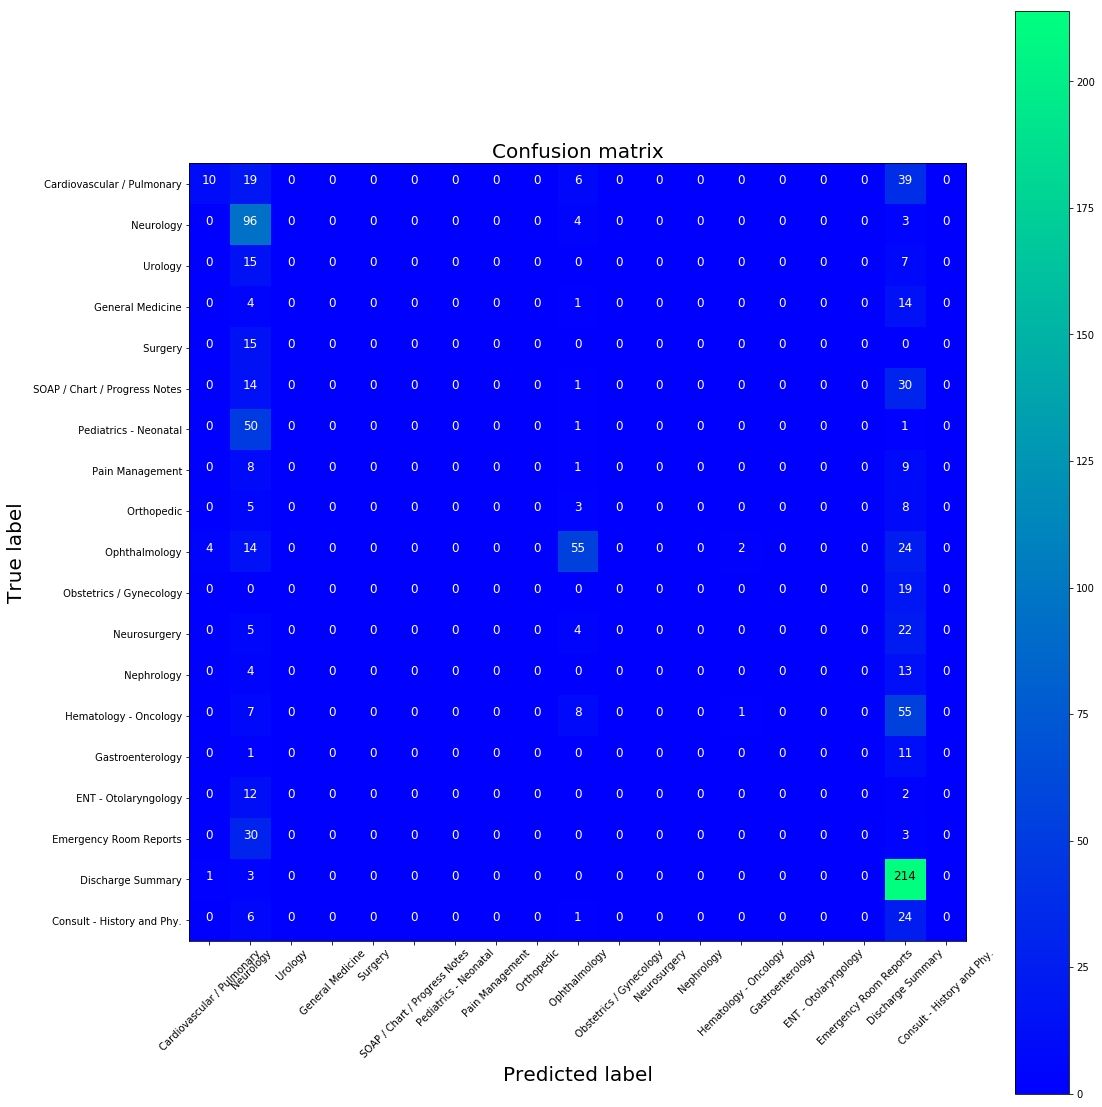

In [58]:
cm2 = confusion_matrix(y_test, y_predict)
fig = plt.figure(figsize=(16, 16))
plot = plot_confusion_matrix(cm2, classes=data_over_50['medical_specialty'].unique(), normalize=False, title='Confusion matrix')
plt.show()

## Another Preprocessing

In [67]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

data = standardize_text(data, "transcription")

KeyError: 'transcription'

In [68]:
# Add class labels

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(data['medical_specialty'])
data.loc[:, 'class_label'] = le.transform(data['medical_specialty'])

In [15]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

data["tokens"] = data["transcription"].apply(tokenizer.tokenize)
data.head()

,transcription,medical_specialty,class_label,tokens
0,"subjective , this 23 year old white female pr...",Allergy / Immunology,0,"[subjective, this, 23, year, old, white, femal..."
1,"past medical history , he has difficulty climb...",Bariatrics,2,"[past, medical, history, he, has, difficulty, ..."
2,"history of present illness , i have seen abc ...",Bariatrics,2,"[history, of, present, illness, i, have, seen,..."
3,"2 d m mode , ,1 left atrial enlargement wit...",Cardiovascular / Pulmonary,3,"[2, d, m, mode, 1, left, atrial, enlargement, ..."
4,1 the left ventricular cavity size and wall ...,Cardiovascular / Pulmonary,3,"[1, the, left, ventricular, cavity, size, and,..."


In [16]:
data = data.rename(index = str, columns = {'transcription': 'text'})

## Inspecting Dataset

In [17]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in data["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

Using TensorFlow backend.


2420957 words total, with a vocabulary size of 22493
Max sentence length is 3114


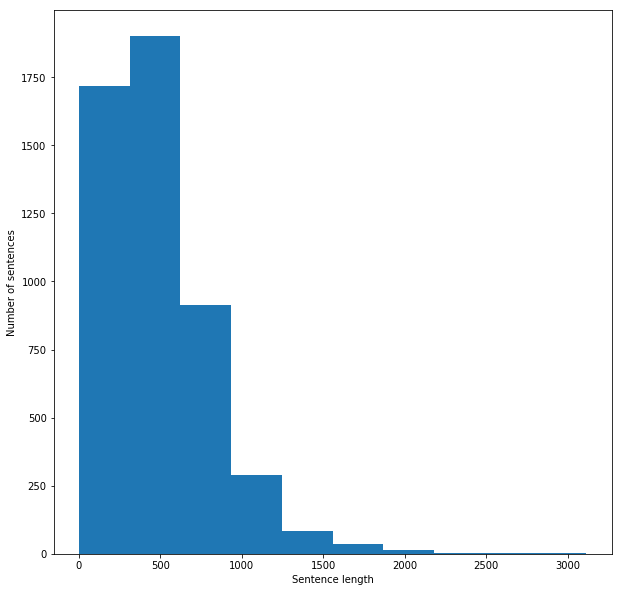

In [69]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

# Approaches

## Bag of words count

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = data["transcription"].tolist()

list_labels = LabelEncoder().fit_transform(data["medical_specialty"]).tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

### Fitting base classifier

In [47]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C = 0.01, solver='saga', multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

### Evaluation

In [48]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.264, precision = 0.208, recall = 0.264, f1 = 0.224


### Inspection

In [49]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=10, rotation = 45)
    plt.yticks(tick_marks, classes, fontsize=10)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=12)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

    return plt

In [52]:
y_predicted_counts

array([ 3, 26, 38,  5, 33, 38,  5, 22, 14,  3, 38, 38, 39, 38, 33, 38, 38,
        5, 38,  5, 27, 27, 38,  5, 38, 14, 27, 38, 25,  5, 38, 15, 15, 20,
       38, 27, 38,  5,  5,  3, 33, 15, 35, 22,  5, 38, 13,  5, 33, 35, 38,
        5, 14, 38, 38, 15, 38, 38, 38, 38, 16,  5, 38, 14,  5,  5, 24,  5,
       27, 33,  5,  7,  3, 38, 33, 38,  5, 22, 38,  3,  4,  5,  5, 38, 38,
        3, 35, 38,  5, 38,  5,  5, 38, 27, 33,  5, 38, 38, 35, 38, 23, 10,
       35, 38, 35, 38, 38, 31, 38, 35, 11, 38, 38, 38,  3, 16, 38, 38,  5,
        5, 33, 38, 38, 38, 33,  5, 10,  5, 38, 11, 38, 38,  5, 38, 20, 38,
       10,  6, 35, 33, 27, 38, 38,  5, 38, 38, 38,  5, 22,  5, 33,  5, 38,
       33, 35,  5, 38, 38, 22, 38, 38, 27, 33,  3, 35,  5, 33,  5,  5, 35,
       38, 38, 38, 12, 38, 27, 33, 24, 38, 38, 27, 35, 38, 22, 38, 38, 22,
       14, 24,  3,  5, 38, 12,  5, 35, 33, 10, 10, 35,  5, 38,  5, 27, 27,
       38,  5,  3, 38, 27, 35, 28,  5,  3, 10,  5, 38, 38, 22, 22, 10, 38,
       38, 38,  5,  5, 15

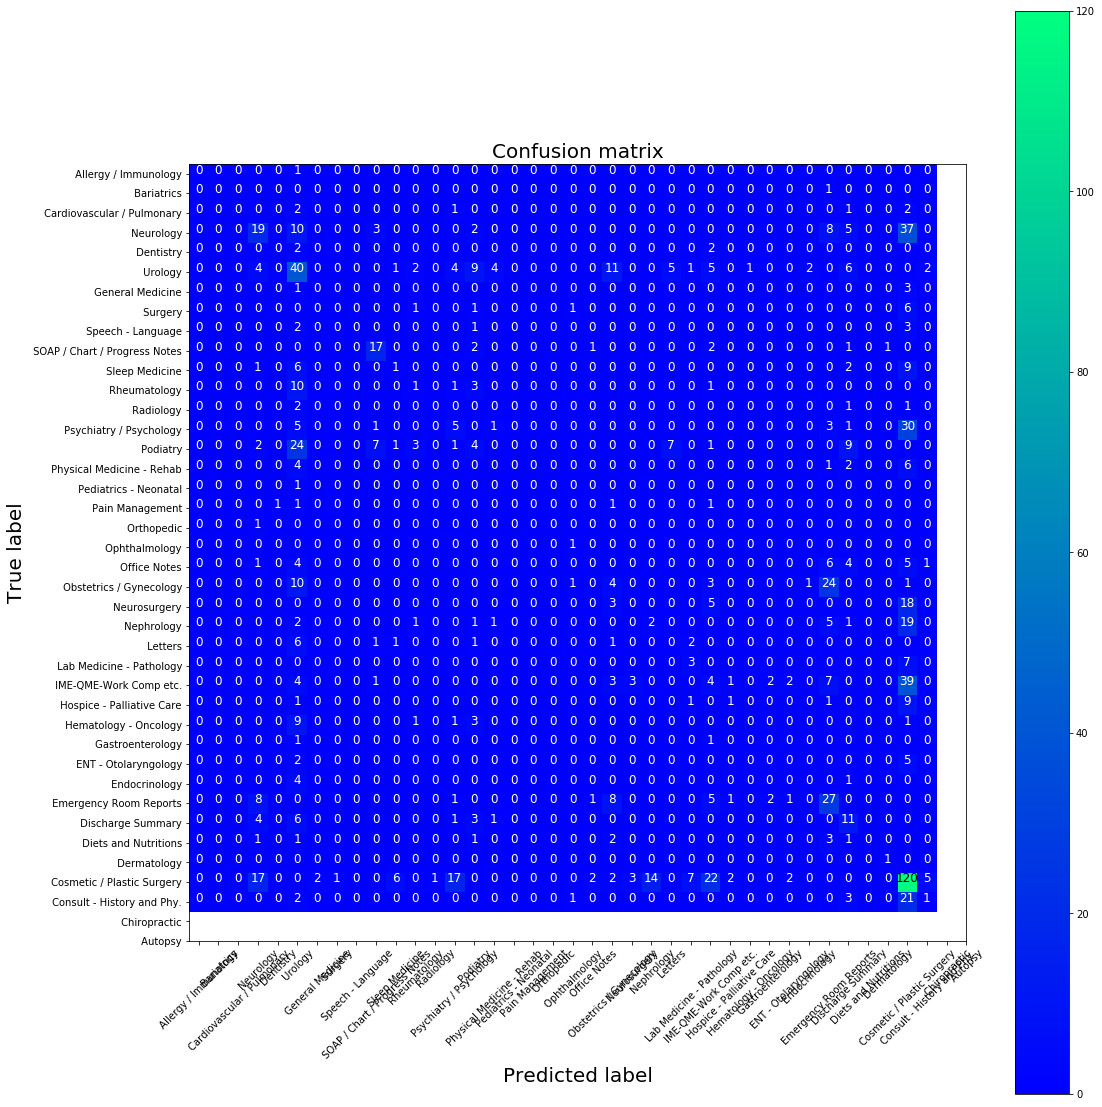

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   2   0]
 ...
 [  0   0   0 ...   1   0   0]
 [  0   0   0 ...   0 120   5]
 [  0   0   0 ...   0  21   1]]


In [50]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(16, 16))
plot = plot_confusion_matrix(cm, classes=data['medical_specialty'].unique(), normalize=False, title='Confusion matrix')
plt.show()
print(cm)

## TF-IDF

In [74]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [75]:
clf_tfidf = LogisticRegression(C = 0.01, solver='saga', multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.229, precision = 0.086, recall = 0.229, f1 = 0.092


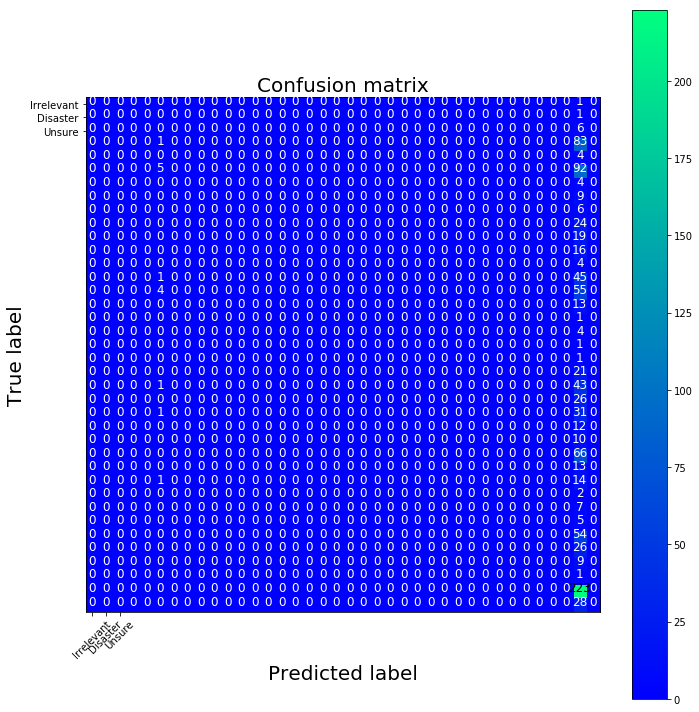

TFIDF confusion matrix
[[  0   0   0 ...   0   1   0]
 [  0   0   0 ...   0   1   0]
 [  0   0   0 ...   0   6   0]
 ...
 [  0   0   0 ...   0   1   0]
 [  0   0   0 ...   0 223   0]
 [  0   0   0 ...   0  28   0]]
BoW confusion matrix
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   2   0]
 ...
 [  0   0   0 ...   1   0   0]
 [  0   0   0 ...   0 120   5]
 [  0   0   0 ...   0  21   1]]


In [27]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

## Word2vec

In [33]:
import gensim

word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [ ]:
embeddings = get_word2vec_embeddings(word2vec, data)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

In [ ]:
clf_w2v = LogisticRegression(C = 0.01, solver='saga', multi_class='multinomial', n_jobs=-1, random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [ ]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

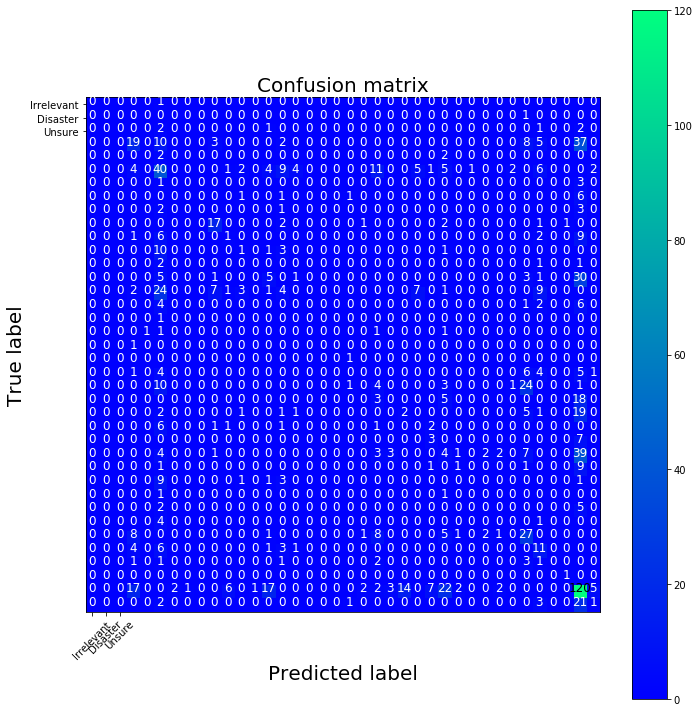

Word2Vec confusion matrix
[[  0   0   0 ...   0   1   0]
 [  0   0   0 ...   0   1   0]
 [  0   0   0 ...   0   6   0]
 ...
 [  0   0   0 ...   0   1   0]
 [  0   0   0 ...   0 223   0]
 [  0   0   0 ...   0  28   0]]
TFIDF confusion matrix
[[  0   0   0 ...   0   1   0]
 [  0   0   0 ...   0   1   0]
 [  0   0   0 ...   0   6   0]
 ...
 [  0   0   0 ...   0   1   0]
 [  0   0   0 ...   0 223   0]
 [  0   0   0 ...   0  28   0]]
BoW confusion matrix
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   2   0]
 ...
 [  0   0   0 ...   1   0   0]
 [  0   0   0 ...   0 120   5]
 [  0   0   0 ...   0  21   1]]


In [33]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

## Results visualization

In [34]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

ModuleNotFoundError: No module named 'lime'

In [ ]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

In [ ]:
import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Irrelevant',
    1: 'Relevant',
    2: 'Unsure'
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

In [ ]:
# First index is the class (Disaster)
# Second index is 0 for detractors, 1 for supporters
# Third is how many words we sample
top_words = sorted_contributions['Relevant']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Relevant']['supporters'][:10].tolist()
bottom_words = sorted_contributions['Relevant']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Relevant']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

## CNN

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(data["text"].tolist())
sequences = tokenizer.texts_to_sequences(data["text"].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(data["class_label"]))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

In [ ]:
from keras.layers import Dense, Input, Flatten, Dropout, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

In [ ]:
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                len(list(data["class_label"].unique())), False)

In [ ]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)

In [ ]:
# Remove CNN?

In [68]:
#Train baseline lables on BOW count

#In the end add LightGBM

#Check new word2vec

## Testing different target sets

In [39]:
data['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Dentistry                          27
 Cosmetic / Plastic Surge

In [10]:
# Drop labels with count <= 50

rares = [' Psychiatry / Psychology', ' Office Notes', ' Podiatry', ' Dermatology', 
' Dentistry', ' Cosmetic / Plastic Surgery', ' Letters', ' Physical Medicine - Rehab',
' Sleep Medicine', ' Endocrinology', ' Bariatrics', ' IME-QME-Work Comp etc.', ' Chiropractic',
' Diets and Nutritions', ' Rheumatology', ' Speech - Language', ' Lab Medicine - Pathology',
' Autopsy', ' Allergy / Immunology', ' Hospice - Palliative Care']

In [61]:
data_over_50 = data.drop(data[data['medical_specialty'].isin(rares)].index)

In [63]:
X_train_tfidf, X_test_tfidf, y_train, y_test = tfidf_preprocessing(data_over_50, ngrams=2)

clf_tfidf = LogisticRegression(C = 0.001, solver='saga', multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.159, precision = 0.025, recall = 0.159, f1 = 0.044


In [65]:
X_train_count, X_test_count, y_train, y_test = count_preprocessing(data_over_50)

clf_count = LogisticRegression(C = 0.001, solver='saga', multi_class='multinomial', n_jobs=-1, random_state=40)
clf_count.fit(X_train_count, y_train)

y_predicted_count = clf_count.predict(X_test_count)

accuracy_count, precision_count, recall_count, f1_count = get_metrics(y_test, y_predicted_count)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_count, precision_count, 
                                                                       recall_count, f1_count))

accuracy = 0.159, precision = 0.025, recall = 0.159, f1 = 0.044


In [66]:
X_train_count

<3115x4 sparse matrix of type '<class 'numpy.int64'>'
	with 0 stored elements in Compressed Sparse Row format>

# Filtering targets

## Functions

In [ ]:
corpus = [x for x in data['transcription'].values]
corpus = [text_prepare(x) for x in data['transcription'].values]
#corpus = standardize_text(data, 'transcription')
#df = CountVectorizer(ngram_range = (1, 2)).fit_transform(corpus)
#df = TfidfVectorizer(ngram_range = (1, 1), stop_words='english').fit_transform(corpus['transcription'])
df = TfidfVectorizer(ngram_range = (1, 1), stop_words='english').fit_transform(corpus)

df.shape

y = data['medical_specialty'].values
x_train, x_test, y_train, y_test = train_test_split(df, y, stratify = y, test_size = 0.2, random_state = 42)

clf = MultinomialNB()
clf.fit(x_train, y_train)

print(f1_score(clf.predict(x_test), y_test, average = 'weighted'))
print(precision_score(clf.predict(x_test), y_test, average = 'weighted'))
print(recall_score(clf.predict(x_test), y_test, average = 'weighted'))
print(accuracy_score(clf.predict(x_test), y_test))

In [59]:
data['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Dentistry                          27
 Cosmetic / Plastic Surge

## Basic (all targets)

In [7]:
def basic_preprocessing(df):
    
    df_temp = df.copy(deep = True)
    
    df_temp = df_temp.rename(index = str, columns = {'transcription': 'text'})
    
    df_temp = df_temp.drop(df_temp[df_temp['text'].isna()].index)
    #corpus = [x for x in df_temp['transcription'].values]
    df_temp.loc[:, 'text'] = [text_prepare(x) for x in df_temp['text'].values]
    
    le = LabelEncoder()
    le.fit(df_temp['medical_specialty'])
    df_temp.loc[:, 'class_label'] = le.transform(df_temp['medical_specialty'])
    
    tokenizer = RegexpTokenizer(r'\w+')

    df_temp["tokens"] = df_temp["text"].apply(tokenizer.tokenize)
    
    return df_temp

def text_prepare(text):

    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
    
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub('', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    words = text.split()
    i = 0
    while i < len(words):
        if words[i] in STOPWORDS:
            words.pop(i)
        else:
            i += 1
    text = ' '.join(map(str, words))# delete stopwords from text
    
    return text

def count_preprocessing(df):
    
    df_temp = df.copy(deep = True)
    df_temp = basic_preprocessing(df_temp)

    count_vectorizer = CountVectorizer()
    count_vectorizer.fit(df_temp['text'])

    list_corpus = df_temp["text"].tolist()
    list_labels = df_temp["class_label"].tolist()
    
    X = count_vectorizer.transform(list_corpus)
    
    return X, list_labels

def tfidf_preprocessing(df, ngrams = 1):
    
    df_temp = basic_preprocessing(df)
    
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, ngrams))
    tfidf_vectorizer.fit(df_temp['text'])

    list_corpus = df_temp["text"].tolist()
    list_labels = df_temp["class_label"].tolist()

    X = tfidf_vectorizer.transform(list_corpus)
    
    return X, list_labels

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    
    if len(tokens_list) < 1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

def word2vec_preprocessing(df):
    
    df_temp = basic_preprocessing(df)
    
    embeddings = get_word2vec_embeddings(word2vec, df_temp)
    list_labels = df_temp["class_label"].tolist()
    
    return embeddings, list_labels

In [8]:
def training_naive(X_train_naive, X_test_naive, y_train_naive, y_test_naive, preproc):
    
    clf = MultinomialNB()
    clf.fit(X_train_naive, y_train_naive)

    res = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])
    
    y_pred = clf.predict(X_test_naive)
    
    f1 = f1_score(y_pred, y_test_naive, average = 'weighted')
    pres = precision_score(y_pred, y_test_naive, average = 'weighted')
    rec = recall_score(y_pred, y_test_naive, average = 'weighted')
    acc = accuracy_score(y_pred, y_test_naive)
    
    res = res.append({'Preprocessing': preproc, 'Model': 'Naive Bayes', 'Precision': pres, 
                     'Recall': rec, 'F1-score': f1, 'Accuracy': acc}, ignore_index = True)

    return res

def training_logreg(X_train_log, X_test_log, y_train_log, y_test_log, preproc, c = 0.001):
    
    folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 40)
    
    #------
    # Test for heavy loaded research
    #clf = LogisticRegressionCV(cv = folds, solver = 'saga', multi_class = 'multinomial', n_jobs = -1)
    clf = LogisticRegression(C = c, solver = 'saga', multi_class = 'multinomial', n_jobs = -1)
    #------
    
    clf.fit(X_train_log, y_train_log)

    res = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])
    
    y_pred = clf.predict(X_test_log)
    
    f1 = f1_score(y_pred, y_test_log, average = 'weighted')
    pres = precision_score(y_pred, y_test_log, average = 'weighted')
    rec = recall_score(y_pred, y_test_log, average = 'weighted')
    acc = accuracy_score(y_pred, y_test_log)
    
    res = res.append({'Preprocessing': preproc, 'Model': f'Logistic Regression c = {c}', 'Precision': pres, 
                     'Recall': rec, 'F1-score': f1, 'Accuracy': acc}, ignore_index = True)

    return res

def training_lgbm(X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm, preproc,
                 n = 120, depth = 2, child = 3, bag = 0.9, feature = 0.9, l1 = 1, l = 0.01, w2v = False):
    
    if w2v:
        d_train = lgb.Dataset(X_train_lgbm, label=y_train_lgbm)
    else:
        d_train = lgb.Dataset(X_train_lgbm.astype(np.float32), label=y_train_lgbm)

    early_stop = 500
    verbose_eval = False
    num_rounds = n

    params = {
        'application': 'regression',
        'objective': 'multiclass',
        'num_class': len(set(y_train_lgbm)),
        'boosting': 'gbdt', 
        'metric': 'multi_logloss',
        'max_depth': depth, 
        'max_bin': 22, 
        'bagging_fraction': bag, 
        'feature_fraction': feature, 
        'min_child_samples': child, 
        'min_child_weight': 1, 
        'learning_rate': l,
        'verbosity': -1, 
        'data_random_seed': 17,
        'lambda_l1': l1}

    model = lgb.train(params, train_set = d_train, num_boost_round = num_rounds)

    y_pred_proba = model.predict(X_test_lgbm.astype(np.float32), num_iteration=model.best_iteration)
    y_pred = [np.argmax(x) for x in y_pred_proba]
    
    res = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])
        
    f1 = f1_score(y_pred, y_test_lgbm, average = 'weighted')
    pres = precision_score(y_pred, y_test_lgbm, average = 'weighted')
    rec = recall_score(y_pred, y_test_lgbm, average = 'weighted')
    acc = accuracy_score(y_pred, y_test_lgbm)
    
    res = res.append({'Preprocessing': preproc, 'Model': 'LightGBM', 'Precision': pres, 
                     'Recall': rec, 'F1-score': f1, 'Accuracy': acc}, ignore_index = True)

    return res

We'll check 3 methods of shortcutting:
- full dataset;
- labels with more than 100 encounters;
- labels with more than 200 encounters;

Also try undersample the major class and oversample the minor ones with SMOKE

### Primary LightGBM setup

Current n: 
100--0.3289738430583501
110--0.323943661971831
120--0.3289738430583501
130--0.3289738430583501


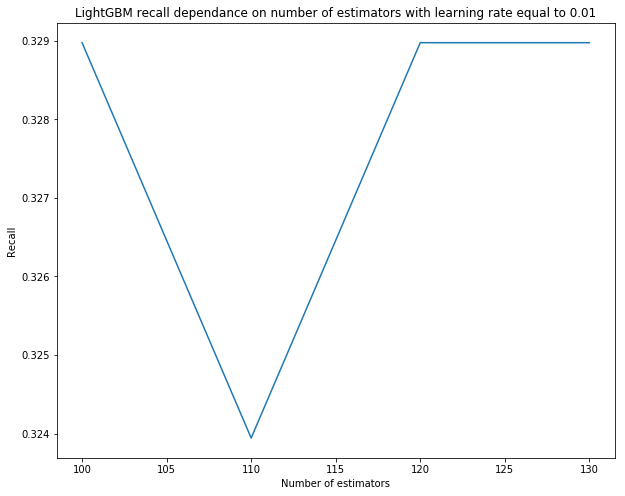

In [19]:
# Tune number of estimator at learning rate = 0.01

X_train, X_test, y_train, y_test = tfidf_preprocessing(data, ngrams = 1)
ns = range(80, 301, 20)
recalls = []
for n in ns:
    recalls.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-gram', n = n, l = 0.01)['Recall'].values[0])
fig = plt.figure(figsize = (10, 8))
plt.plot(ns, recalls, label = 'Recall')
plt.xlabel('Number of estimators')
plt.ylabel('Recall')
plt.title('LightGBM recall dependance on number of estimators with learning rate equal to 0.01')
plt.show()

In [21]:
# Tune maximum tree depth and minimum elements in leaf

depths = range(2, 11, 2)
childs = range(1, 10, 2)
recalls = []
for depth in depths:
    for child in childs:
        recalls.append([training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-gram', 
                                     n = 120, l = 0.01, depth = depth, child = child)['Recall'].values[0], depth, child])
recalls.sort(reverse = True)

In [23]:
recalls

[[0.35110663983903423, 2, 3],
 [0.34909456740442657, 2, 9],
 [0.34909456740442657, 2, 7],
 [0.34909456740442657, 2, 5],
 [0.34909456740442657, 2, 1],
 [0.30885311871227367, 4, 9],
 [0.30181086519114686, 4, 1],
 [0.29979879275653926, 4, 7],
 [0.29577464788732394, 4, 3],
 [0.2917505030181087, 4, 5],
 [0.24044265593561368, 6, 9],
 [0.23943661971830985, 6, 7],
 [0.23641851106639838, 6, 3],
 [0.23340040241448692, 6, 1],
 [0.23038229376257546, 10, 9],
 [0.23038229376257546, 6, 5],
 [0.22937625754527163, 8, 9],
 [0.22032193158953722, 10, 7],
 [0.21730382293762576, 10, 5],
 [0.2152917505030181, 10, 3],
 [0.2152917505030181, 8, 7],
 [0.21327967806841047, 10, 1],
 [0.21327967806841047, 8, 5],
 [0.2112676056338028, 8, 3],
 [0.21026156941649898, 8, 1]]

### Full dataset

In [88]:
# DataFrame for result evaluation

full_result = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

In [90]:
# Testing Count Vectorizer on Naive Bayes, Logistic Regression and LightGBM

X_train, X_test, y_train, y_test = count_preprocessing(data)
full_result = full_result.append(training_naive(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.001), ignore_index = True)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.01), ignore_index = True)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.1), ignore_index = True)
full_result = full_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)

# Testing TF-IDF with 1-gram on Naive Bayes, Logistic Regression and LightGBM

X_train, X_test, y_train, y_test = tfidf_preprocessing(data, ngrams = 1)
full_result = full_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.001), ignore_index = True)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.01), ignore_index = True)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.1), ignore_index = True)
full_result = full_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)

# Testing TF-IDF with 2-gram on Naive Bayes, Logistic Regression and LightGBM

X_train, X_test, y_train, y_test = tfidf_preprocessing(data, ngrams = 2)
full_result = full_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.001), ignore_index = True)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.01), ignore_index = True)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.1), ignore_index = True)
full_result = full_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)

# Testing Word2vec on Naive Bayes, Logistic Regression and LightGBM

X_train, X_test, y_train, y_test = word2vec_preprocessing(data)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.001), ignore_index = True)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.01), ignore_index = True)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.1), ignore_index = True)

full_result.to_csv('Compare.csv', index = False)
full_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Count Vectorize,Naive Bayes,0.437086,0.279678,0.322762,0.279678
1,Count Vectorize,Logistic Regression c = 0.001,0.580458,0.330986,0.405329,0.330986
2,Count Vectorize,Logistic Regression c = 0.01,0.160179,0.137827,0.146651,0.137827
3,Count Vectorize,Logistic Regression c = 0.1,0.106620,0.099598,0.101865,0.099598
4,Count Vectorize,LightGBM,0.758551,0.344064,0.444860,0.344064
5,TF-IDF 1-grams,Naive Bayes,0.955007,0.322938,0.474105,0.322938
6,TF-IDF 1-grams,Logistic Regression c = 0.001,1.000000,0.224346,0.366475,0.224346
7,TF-IDF 1-grams,Logistic Regression c = 0.01,1.000000,0.224346,0.366475,0.224346
8,TF-IDF 1-grams,Logistic Regression c = 0.1,0.949399,0.309859,0.465162,0.309859
9,TF-IDF 1-grams,LightGBM,0.745439,0.351107,0.449898,0.351107


### Drop the labels with less than 100 observations

In [83]:
counts = data['medical_specialty'].value_counts()
data_100 = data[data['medical_specialty'].isin(counts[counts > 100].index)]

In [84]:
data_100['medical_specialty'].value_counts()

 Surgery                          1103
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        372
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  230
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Obstetrics / Gynecology           160
 Urology                           158
 Discharge Summary                 108
Name: medical_specialty, dtype: int64

In [91]:
drop_100_result = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

# Testing Count Vectorizer on Naive Bayes, Logistic Regression and LightGBM

X_train, X_test, y_train, y_test = count_preprocessing(data_100)
drop_100_result = drop_100_result.append(training_naive(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
drop_100_result = drop_100_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.001), ignore_index = True)
drop_100_result = drop_100_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.01), ignore_index = True)
drop_100_result = drop_100_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.1), ignore_index = True)
drop_100_result = drop_100_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)

# Testing TF-IDF with 1-gram on Naive Bayes, Logistic Regression and LightGBM

X_train, X_test, y_train, y_test = tfidf_preprocessing(data_100, ngrams = 1)
drop_100_result = drop_100_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
drop_100_result = drop_100_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.001), ignore_index = True)
drop_100_result = drop_100_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.01), ignore_index = True)
drop_100_result = drop_100_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.1), ignore_index = True)
drop_100_result = drop_100_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)

# Testing TF-IDF with 2-gram on Naive Bayes, Logistic Regression and LightGBM

X_train, X_test, y_train, y_test = tfidf_preprocessing(data_100, ngrams = 2)
drop_100_result = drop_100_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)
drop_100_result = drop_100_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.001), ignore_index = True)
drop_100_result = drop_100_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.01), ignore_index = True)
drop_100_result = drop_100_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.1), ignore_index = True)
drop_100_result = drop_100_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)

# Testing Word2vec on Naive Bayes, Logistic Regression and LightGBM

X_train, X_test, y_train, y_test = word2vec_preprocessing(data_100)
drop_100_result = drop_100_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.001), ignore_index = True)
drop_100_result = drop_100_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.01), ignore_index = True)
drop_100_result = drop_100_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.1), ignore_index = True)

drop_100_result.to_csv('Compare_100.csv', index = False)
drop_100_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Count Vectorize,Naive Bayes,0.455078,0.388960,0.413204,0.388960
1,Count Vectorize,Logistic Regression c = 0.001,0.596802,0.428755,0.489706,0.428755
2,Count Vectorize,Logistic Regression c = 0.01,0.271458,0.250321,0.259615,0.250321
3,Count Vectorize,Logistic Regression c = 0.1,0.232587,0.224647,0.228077,0.224647
4,Count Vectorize,LightGBM,0.790903,0.427471,0.531446,0.427471
5,TF-IDF 1-grams,Naive Bayes,0.954386,0.426187,0.587129,0.426187
6,TF-IDF 1-grams,Logistic Regression c = 0.001,1.000000,0.277279,0.434171,0.277279
7,TF-IDF 1-grams,Logistic Regression c = 0.01,1.000000,0.277279,0.434171,0.277279
8,TF-IDF 1-grams,Logistic Regression c = 0.1,0.941250,0.406932,0.563538,0.406932
9,TF-IDF 1-grams,LightGBM,0.776527,0.432606,0.535014,0.432606


### Drop the labels with less than 200 observations

In [92]:
counts = data['medical_specialty'].value_counts()
data_200 = data[data['medical_specialty'].isin(counts[counts > 200].index)]

In [93]:
data_200['medical_specialty'].value_counts()

 Surgery                       1103
 Consult - History and Phy.     516
 Cardiovascular / Pulmonary     372
 Orthopedic                     355
 Radiology                      273
 General Medicine               259
 Gastroenterology               230
 Neurology                      223
Name: medical_specialty, dtype: int64

In [94]:
drop_200_result = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

# Testing Count Vectorizer on Naive Bayes, Logistic Regression and LightGBM

X_train, X_test, y_train, y_test = count_preprocessing(data_200)
drop_200_result = drop_200_result.append(training_naive(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
drop_200_result = drop_200_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.001), ignore_index = True)
drop_200_result = drop_200_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.01), ignore_index = True)
drop_200_result = drop_200_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.1), ignore_index = True)
drop_200_result = drop_200_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)

# Testing TF-IDF with 1-gram on Naive Bayes, Logistic Regression and LightGBM

X_train, X_test, y_train, y_test = tfidf_preprocessing(data_200, ngrams = 1)
drop_200_result = drop_200_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
drop_200_result = drop_200_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.001), ignore_index = True)
drop_200_result = drop_200_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.01), ignore_index = True)
drop_200_result = drop_200_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.1), ignore_index = True)
drop_200_result = drop_200_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)

# Testing TF-IDF with 2-gram on Naive Bayes, Logistic Regression and LightGBM

X_train, X_test, y_train, y_test = tfidf_preprocessing(data_200, ngrams = 2)
drop_200_result = drop_200_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)
drop_200_result = drop_200_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.001), ignore_index = True)
drop_200_result = drop_200_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.01), ignore_index = True)
drop_200_result = drop_200_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.1), ignore_index = True)
drop_200_result = drop_200_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)

# Testing Word2vec on Naive Bayes, Logistic Regression and LightGBM

X_train, X_test, y_train, y_test = word2vec_preprocessing(data_200)
drop_200_result = drop_200_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.001), ignore_index = True)
drop_200_result = drop_200_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.01), ignore_index = True)
drop_200_result = drop_200_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.1), ignore_index = True)

drop_200_result.to_csv('Compare_200.csv', index = False)
drop_200_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Count Vectorize,Naive Bayes,0.493900,0.447130,0.458675,0.447130
1,Count Vectorize,Logistic Regression c = 0.001,0.583273,0.477341,0.514732,0.477341
2,Count Vectorize,Logistic Regression c = 0.01,0.363005,0.351964,0.356739,0.351964
3,Count Vectorize,Logistic Regression c = 0.1,0.331889,0.329305,0.330229,0.329305
4,Count Vectorize,LightGBM,0.836281,0.483384,0.591899,0.483384
5,TF-IDF 1-grams,Naive Bayes,0.919971,0.477341,0.619257,0.477341
6,TF-IDF 1-grams,Logistic Regression c = 0.001,1.000000,0.320242,0.485126,0.320242
7,TF-IDF 1-grams,Logistic Regression c = 0.01,1.000000,0.320242,0.485126,0.320242
8,TF-IDF 1-grams,Logistic Regression c = 0.1,0.924100,0.445619,0.596406,0.445619
9,TF-IDF 1-grams,LightGBM,0.808807,0.481873,0.589515,0.481873


CONFUSION MATRIX HERE

### Try to undersample the major class

In [99]:
from imblearn.under_sampling import TomekLinks, RepeatedEditedNearestNeighbours

In [108]:
# DataFrame for result evaluation

tl = TomekLinks()

full_result_under = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

# Testing Count Vectorizer on Naive Bayes, Logistic Regression and LightGBM

X, y = count_preprocessing(data)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
full_result_under = full_result_under.append(training_naive(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
full_result_under = full_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.001), ignore_index = True)
full_result_under = full_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.01), ignore_index = True)
full_result_under = full_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.1), ignore_index = True)
full_result_under = full_result_under.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)

# Testing TF-IDF with 1-gram on Naive Bayes, Logistic Regression and LightGBM

X, y = tfidf_preprocessing(data, ngrams = 1)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
full_result_under = full_result_under.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
full_result_under = full_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.001), ignore_index = True)
full_result_under = full_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.01), ignore_index = True)
full_result_under = full_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.1), ignore_index = True)
full_result_under = full_result_under.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)

# Testing TF-IDF with 2-gram on Naive Bayes, Logistic Regression and LightGBM

X, y = tfidf_preprocessing(data, ngrams = 2)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
full_result_under = full_result_under.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)
full_result_under = full_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.001), ignore_index = True)
full_result_under = full_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.01), ignore_index = True)
full_result_under = full_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.1), ignore_index = True)
full_result_under = full_result_under.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)

# Testing Word2vec on Naive Bayes, Logistic Regression and LightGBM

X, y = word2vec_preprocessing(data)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
full_result_under = full_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.001), ignore_index = True)
full_result_under = full_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.01), ignore_index = True)
full_result_under = full_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.1), ignore_index = True)

full_result_under.to_csv('Compare_under.csv', index = False)
full_result_under

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Count Vectorize,Naive Bayes,0.560095,0.363354,0.406740,0.363354
1,Count Vectorize,Logistic Regression c = 0.001,0.525150,0.402174,0.432116,0.402174
2,Count Vectorize,Logistic Regression c = 0.01,0.386211,0.364907,0.369761,0.364907
3,Count Vectorize,Logistic Regression c = 0.1,0.365465,0.355590,0.357228,0.355590
4,Count Vectorize,LightGBM,0.477074,0.397516,0.415650,0.397516
5,TF-IDF 1-grams,Naive Bayes,0.789928,0.299392,0.364513,0.299392
6,TF-IDF 1-grams,Logistic Regression c = 0.001,1.000000,0.092705,0.169680,0.092705
7,TF-IDF 1-grams,Logistic Regression c = 0.01,1.000000,0.092705,0.169680,0.092705
8,TF-IDF 1-grams,Logistic Regression c = 0.1,0.802121,0.249240,0.327639,0.249240
9,TF-IDF 1-grams,LightGBM,0.477990,0.390578,0.404333,0.390578


In [110]:
# DataFrame for result evaluation

tl = TomekLinks()

drop_100_result_under = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

# Testing Count Vectorizer on Naive Bayes, Logistic Regression and LightGBM

X, y = count_preprocessing(data_100)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
drop_100_result_under = drop_100_result_under.append(training_naive(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
drop_100_result_under = drop_100_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.001), ignore_index = True)
drop_100_result_under = drop_100_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.01), ignore_index = True)
drop_100_result_under = drop_100_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.1), ignore_index = True)
drop_100_result_under = drop_100_result_under.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)

# Testing TF-IDF with 1-gram on Naive Bayes, Logistic Regression and LightGBM

X, y = tfidf_preprocessing(data_100, ngrams = 1)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
drop_100_result_under = drop_100_result_under.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
drop_100_result_under = drop_100_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.001), ignore_index = True)
drop_100_result_under = drop_100_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.01), ignore_index = True)
drop_100_result_under = drop_100_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.1), ignore_index = True)
drop_100_result_under = drop_100_result_under.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)

# Testing TF-IDF with 2-gram on Naive Bayes, Logistic Regression and LightGBM

X, y = tfidf_preprocessing(data_100, ngrams = 2)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
drop_100_result_under = drop_100_result_under.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)
drop_100_result_under = drop_100_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.001), ignore_index = True)
drop_100_result_under = drop_100_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.01), ignore_index = True)
drop_100_result_under = drop_100_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.1), ignore_index = True)
drop_100_result_under = drop_100_result_under.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)

# Testing Word2vec on Naive Bayes, Logistic Regression and LightGBM

X, y = word2vec_preprocessing(data_100)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
drop_100_result_under = drop_100_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.001), ignore_index = True)
drop_100_result_under = drop_100_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.01), ignore_index = True)
drop_100_result_under = drop_100_result_under.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.1), ignore_index = True)

drop_100_result_under.to_csv('Compare_100_under.csv', index = False)
drop_100_result_under

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Count Vectorize,Naive Bayes,0.593515,0.497186,0.522294,0.497186
1,Count Vectorize,Logistic Regression c = 0.001,0.629922,0.570356,0.584363,0.570356
2,Count Vectorize,Logistic Regression c = 0.01,0.508846,0.506567,0.504830,0.506567
3,Count Vectorize,Logistic Regression c = 0.1,0.487978,0.491557,0.487643,0.491557
4,Count Vectorize,LightGBM,0.513253,0.478424,0.486634,0.478424
5,TF-IDF 1-grams,Naive Bayes,0.774476,0.508167,0.591374,0.508167
6,TF-IDF 1-grams,Logistic Regression c = 0.001,1.000000,0.147005,0.256329,0.147005
7,TF-IDF 1-grams,Logistic Regression c = 0.01,0.876451,0.277677,0.381334,0.277677
8,TF-IDF 1-grams,Logistic Regression c = 0.1,0.786095,0.451906,0.555340,0.451906
9,TF-IDF 1-grams,LightGBM,0.539177,0.482759,0.489346,0.482759


In [9]:
from imblearn.over_sampling import SMOTE, ADASYN

t2 = SMOTE()

full_result_smote = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

# Testing Count Vectorizer on Naive Bayes, Logistic Regression and LightGBM
X, y = count_preprocessing(data)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
full_result_smote = full_result_smote.append(training_naive(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
full_result_smote = full_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.001), ignore_index = True)
full_result_smote = full_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.01), ignore_index = True)
full_result_smote = full_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.1), ignore_index = True)
full_result_smote = full_result_smote.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)

full_result_smote

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Count Vectorize,Naive Bayes,0.809888,0.770910,0.783612,0.770910
1,Count Vectorize,Logistic Regression c = 0.001,0.819645,0.766774,0.785952,0.766774
2,Count Vectorize,Logistic Regression c = 0.01,0.847687,0.803768,0.820381,0.803768
3,Count Vectorize,Logistic Regression c = 0.1,0.841131,0.805147,0.818822,0.805147
4,Count Vectorize,LightGBM,0.756114,0.698529,0.717100,0.698529


In [10]:
len(set(y))

40

In [18]:
len(X_train.todense().shape)

MemoryError: 

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN

# DataFrame for result evaluation

t2 = SMOTE()

full_result_smote = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

# Testing Count Vectorizer on Naive Bayes, Logistic Regression and LightGBM
X, y = count_preprocessing(data)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
full_result_smote = full_result_smote.append(training_naive(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
full_result_smote = full_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.001), ignore_index = True)
full_result_smote = full_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.01), ignore_index = True)
full_result_smote = full_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.1), ignore_index = True)
full_result_smote = full_result_smote.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)

# Testing TF-IDF with 1-gram on Naive Bayes, Logistic Regression and LightGBM

X, y = tfidf_preprocessing(data, ngrams = 1)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
full_result_smote = full_result_smote.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
full_result_smote = full_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.001), ignore_index = True)
full_result_smote = full_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.01), ignore_index = True)
full_result_smote = full_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.1), ignore_index = True)
full_result_smote = full_result_smote.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)

# Testing TF-IDF with 2-gram on Naive Bayes, Logistic Regression and LightGBM

X, y = tfidf_preprocessing(data, ngrams = 2)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
full_result_smote = full_result_smote.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)
full_result_smote = full_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.001), ignore_index = True)
full_result_smote = full_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.01), ignore_index = True)
full_result_smote = full_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.1), ignore_index = True)
full_result_smote = full_result_smote.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)

# Testing Word2vec on Naive Bayes, Logistic Regression and LightGBM

X, y = word2vec_preprocessing(data)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
full_result_smote = full_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.001), ignore_index = True)
full_result_smote = full_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.01), ignore_index = True)
full_result_smote = full_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.1), ignore_index = True)

full_result_smote.to_csv('Compare_smote.csv', index = False)
full_result_smote

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN

# DataFrame for result evaluation

t2 = SMOTE()

data_100_result_smote = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

# Testing Count Vectorizer on Naive Bayes, Logistic Regression and LightGBM

X, y = count_preprocessing(data_100)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
data_100_result_smote = data_100_result_smote.append(training_naive(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
data_100_result_smote = data_100_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.001), ignore_index = True)
data_100_result_smote = data_100_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.01), ignore_index = True)
data_100_result_smote = data_100_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.1), ignore_index = True)
data_100_result_smote = data_100_result_smote.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)

# Testing TF-IDF with 1-gram on Naive Bayes, Logistic Regression and LightGBM

X, y = tfidf_preprocessing(data_100, ngrams = 1)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
full_result_smote = full_result_smote.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
full_result_smote = full_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.001), ignore_index = True)
full_result_smote = full_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.01), ignore_index = True)
full_result_smote = full_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.1), ignore_index = True)
full_result_smote = full_result_smote.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)

# Testing TF-IDF with 2-gram on Naive Bayes, Logistic Regression and LightGBM

X, y = tfidf_preprocessing(data_100, ngrams = 2)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
data_100_result_smote = data_100_result_smote.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)
data_100_result_smote = data_100_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.001), ignore_index = True)
data_100_result_smote = data_100_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.01), ignore_index = True)
data_100_result_smote = data_100_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.1), ignore_index = True)
data_100_result_smote = data_100_result_smote.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)

# Testing Word2vec on Naive Bayes, Logistic Regression and LightGBM

X, y = word2vec_preprocessing(data_100)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
data_100_result_smote = data_100_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.001), ignore_index = True)
data_100_result_smote = data_100_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.01), ignore_index = True)
data_100_result_smote = data_100_result_smote.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.1), ignore_index = True)

data_100_result_smote.to_csv('Compare_100_smote.csv', index = False)
data_100_result_smote

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN

# DataFrame for result evaluation

t2 = ADASYN()

full_result_adasyn = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

# Testing Count Vectorizer on Naive Bayes, Logistic Regression and LightGBM
X, y = count_preprocessing(data)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
full_result_adasyn = full_result_adasyn.append(training_naive(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
full_result_adasyn = full_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.001), ignore_index = True)
full_result_adasyn = full_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.01), ignore_index = True)
full_result_adasyn = full_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.1), ignore_index = True)
full_result_adasyn = full_result_adasyn.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)

# Testing TF-IDF with 1-gram on Naive Bayes, Logistic Regression and LightGBM

X, y = tfidf_preprocessing(data, ngrams = 1)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
full_result_adasyn = full_result_adasyn.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
full_result_adasyn = full_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.001), ignore_index = True)
full_result_adasyn = full_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.01), ignore_index = True)
full_result_adasyn = full_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.1), ignore_index = True)
full_result_adasyn = full_result_adasyn.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)

# Testing TF-IDF with 2-gram on Naive Bayes, Logistic Regression and LightGBM

X, y = tfidf_preprocessing(data, ngrams = 2)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
full_result_adasyn = full_result_adasyn.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)
full_result_adasyn = full_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.001), ignore_index = True)
full_result_adasyn = full_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.01), ignore_index = True)
full_result_adasyn = full_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.1), ignore_index = True)
full_result_adasyn = full_result_adasyn.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)

# Testing Word2vec on Naive Bayes, Logistic Regression and LightGBM

X, y = word2vec_preprocessing(data)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
full_result_adasyn = full_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.001), ignore_index = True)
full_result_adasyn = full_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.01), ignore_index = True)
full_result_adasyn = full_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.1), ignore_index = True)

full_result_adasyn.to_csv('Compare_adasyn.csv', index = False)
full_result_adasyn

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN

# DataFrame for result evaluation

t2 = ADASYN()

data_100_result_smote = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

# Testing Count Vectorizer on Naive Bayes, Logistic Regression and LightGBM

X, y = count_preprocessing(data_100)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
data_100_result_adasyn = data_100_result_adasyn.append(training_naive(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
data_100_result_adasyn = data_100_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.001), ignore_index = True)
data_100_result_adasyn = data_100_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.01), ignore_index = True)
data_100_result_adasyn = data_100_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize', c = 0.1), ignore_index = True)
data_100_result_adasyn = data_100_result_adasyn.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)

# Testing TF-IDF with 1-gram on Naive Bayes, Logistic Regression and LightGBM

X, y = tfidf_preprocessing(data_100, ngrams = 1)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
data_100_result_adasyn = data_100_result_adasyn.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
data_100_result_adasyn = data_100_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.001), ignore_index = True)
data_100_result_adasyn = data_100_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.01), ignore_index = True)
data_100_result_adasyn = data_100_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams', c = 0.1), ignore_index = True)
data_100_result_adasyn = data_100_result_adasyn.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)

# Testing TF-IDF with 2-gram on Naive Bayes, Logistic Regression and LightGBM

X, y = tfidf_preprocessing(data_100, ngrams = 2)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
data_100_result_adasyn = data_100_result_adasyn.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)
data_100_result_adasyn = data_100_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.001), ignore_index = True)
data_100_result_adasyn = data_100_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.01), ignore_index = True)
data_100_result_adasyn = data_100_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams', c = 0.1), ignore_index = True)
data_100_result_adasyn = data_100_result_adasyn.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)

# Testing Word2vec on Naive Bayes, Logistic Regression and LightGBM

X, y = word2vec_preprocessing(data_100)
X, y = t2.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
data_100_result_adasyn = data_100_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.001), ignore_index = True)
data_100_result_adasyn = data_100_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.01), ignore_index = True)
data_100_result_adasyn = data_100_result_adasyn.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec', c = 0.1), ignore_index = True)

data_100_result_adasyn.to_csv('Compare_100_adasyn.csv', index = False)
data_100_result_adasyn

In [102]:
from imblearn.under_sampling import TomekLinks, RepeatedEditedNearestNeighbours, AllKNN

t2 = AllKNN(sampling_strategy='majority')

X_train, X_test, y_train, y_test = count_preprocessing(data)
print(len(X_train.todense()))
X_train, y_train = t2.fit_resample(X_train, y_train)
print(len(X_train.todense()))

3972
2698


In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN